In [47]:
from bankingSystem import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [48]:
# simulation and data collection
simulationSteps = 500
model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                 leverageRatio = 11.0,                                     # leverage ratio upper bound for all banks
                 capitalReserve = 0.0,                                     # capital reserve as a ratio of portfolio value
                 num_borrowing= 20,                                        # number of borrowing request per bank per step
                 sizeOfBorrowing = 1,                                      # size of borrowing as a ratio of equity capital
                 num_banks=100,                                            # number of banks in the system 
                 alpha = 0.5,                                              # portfolio recovery rate                           
                 beta = 0.9,                                               # interbank loan recovery rate
                 fedRate = 0.0,                                            # interest rate on borrowing   
                 portfolioReturnRate = 0.0,                                # return rate on portfolio
                 liquidityShockNum = 3,                                    # number of liquidity shocks per step      
                 shockSize = 0.1,                                          # size of the shock
                 shockDuration =  [simulationSteps // 10 * 6, simulationSteps // 10 * 7]) # duration of the shock
                 
model.datacollector.collect(model)
for i in tqdm(range(simulationSteps)):
    model.simulate()

agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

100%|██████████| 500/500 [01:01<00:00,  8.19it/s]


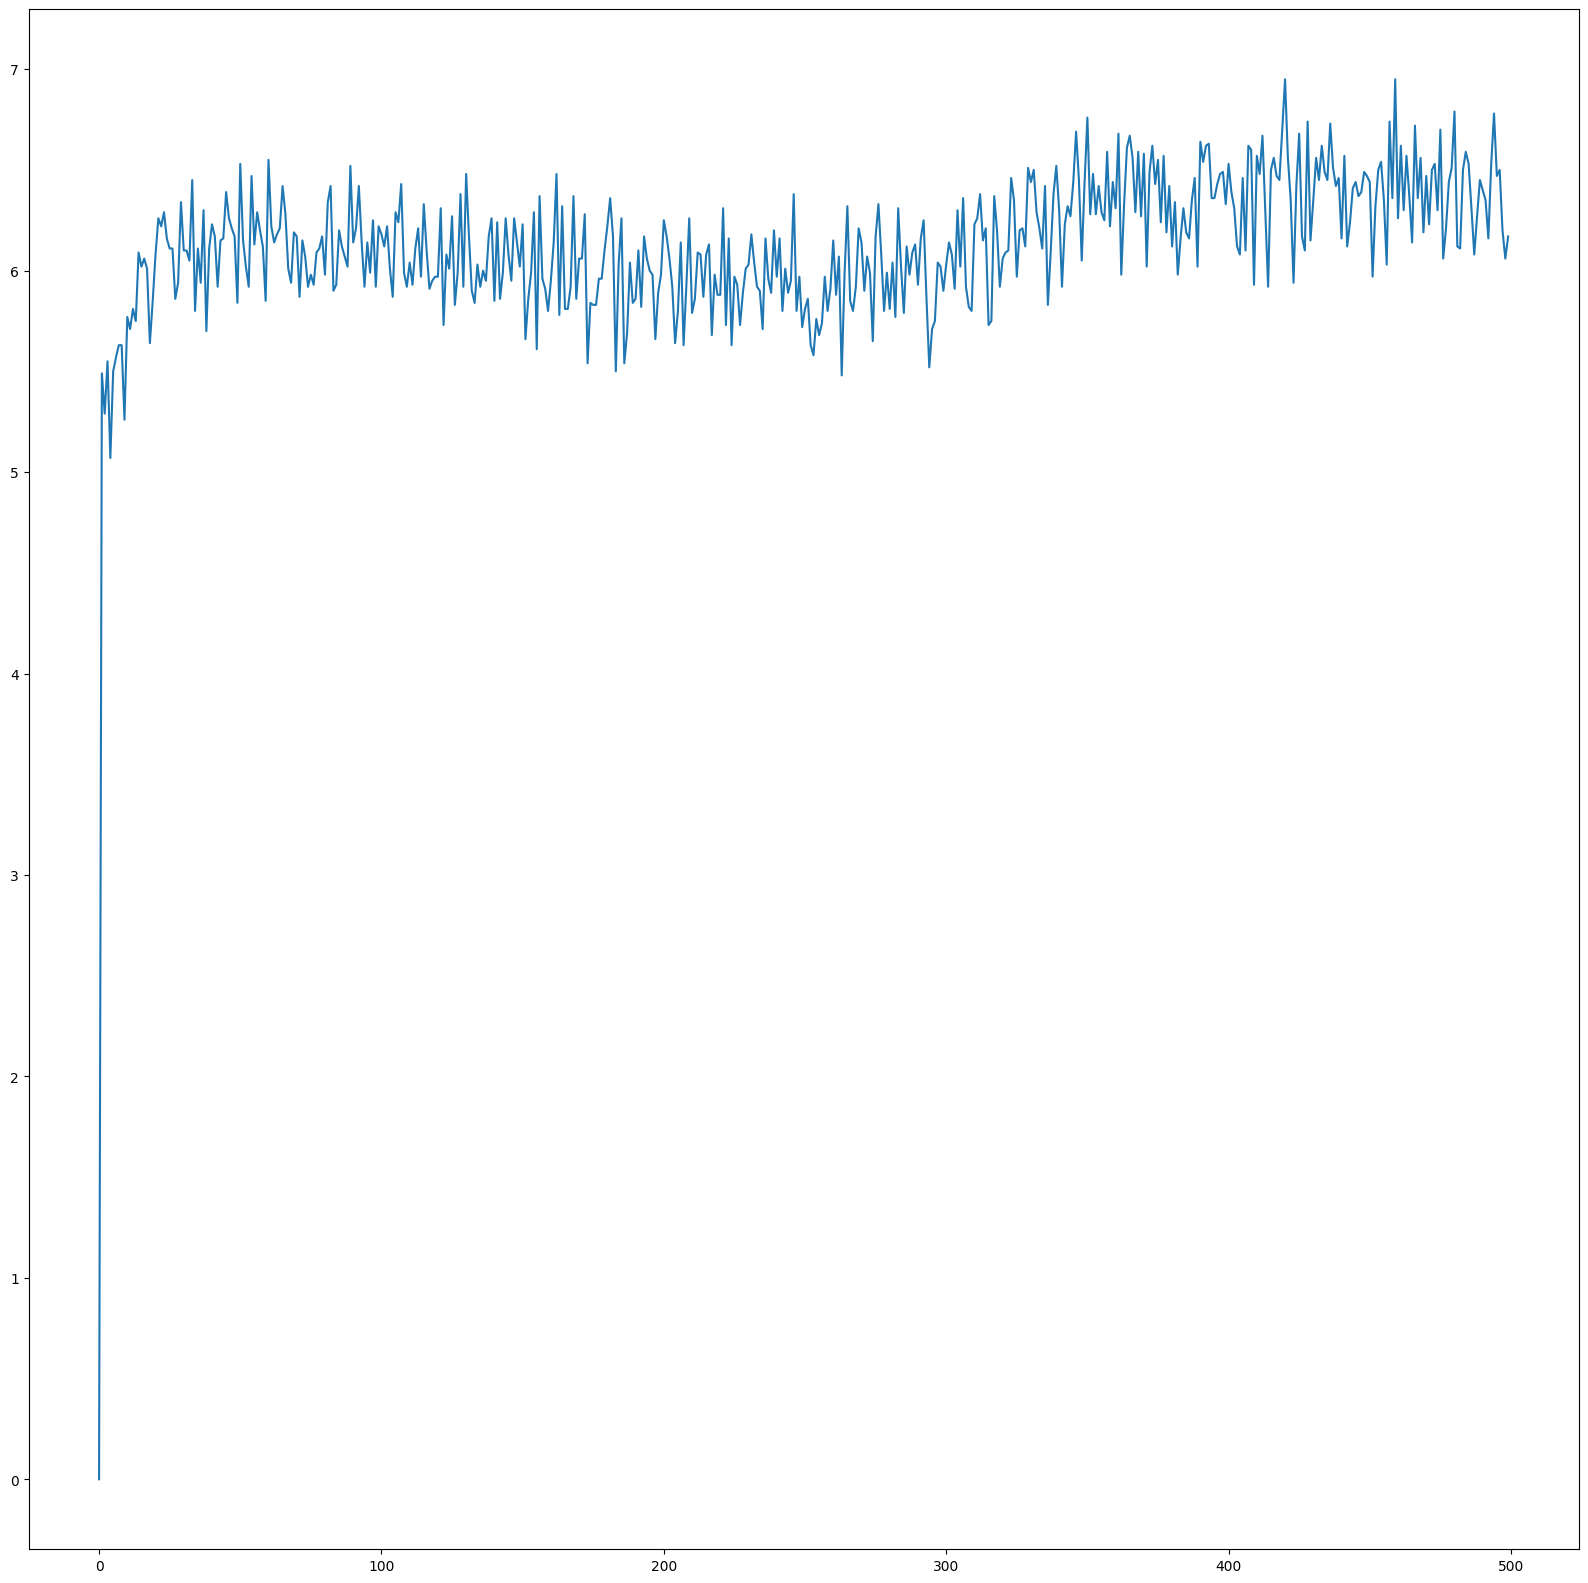

In [49]:
plt.plot([agent_data.xs(i, level="Step")["Leverage"].mean() for i in range(simulationSteps)])

(array([ 5.,  7.,  5.,  5., 14., 10.,  7.,  7.,  6., 26.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

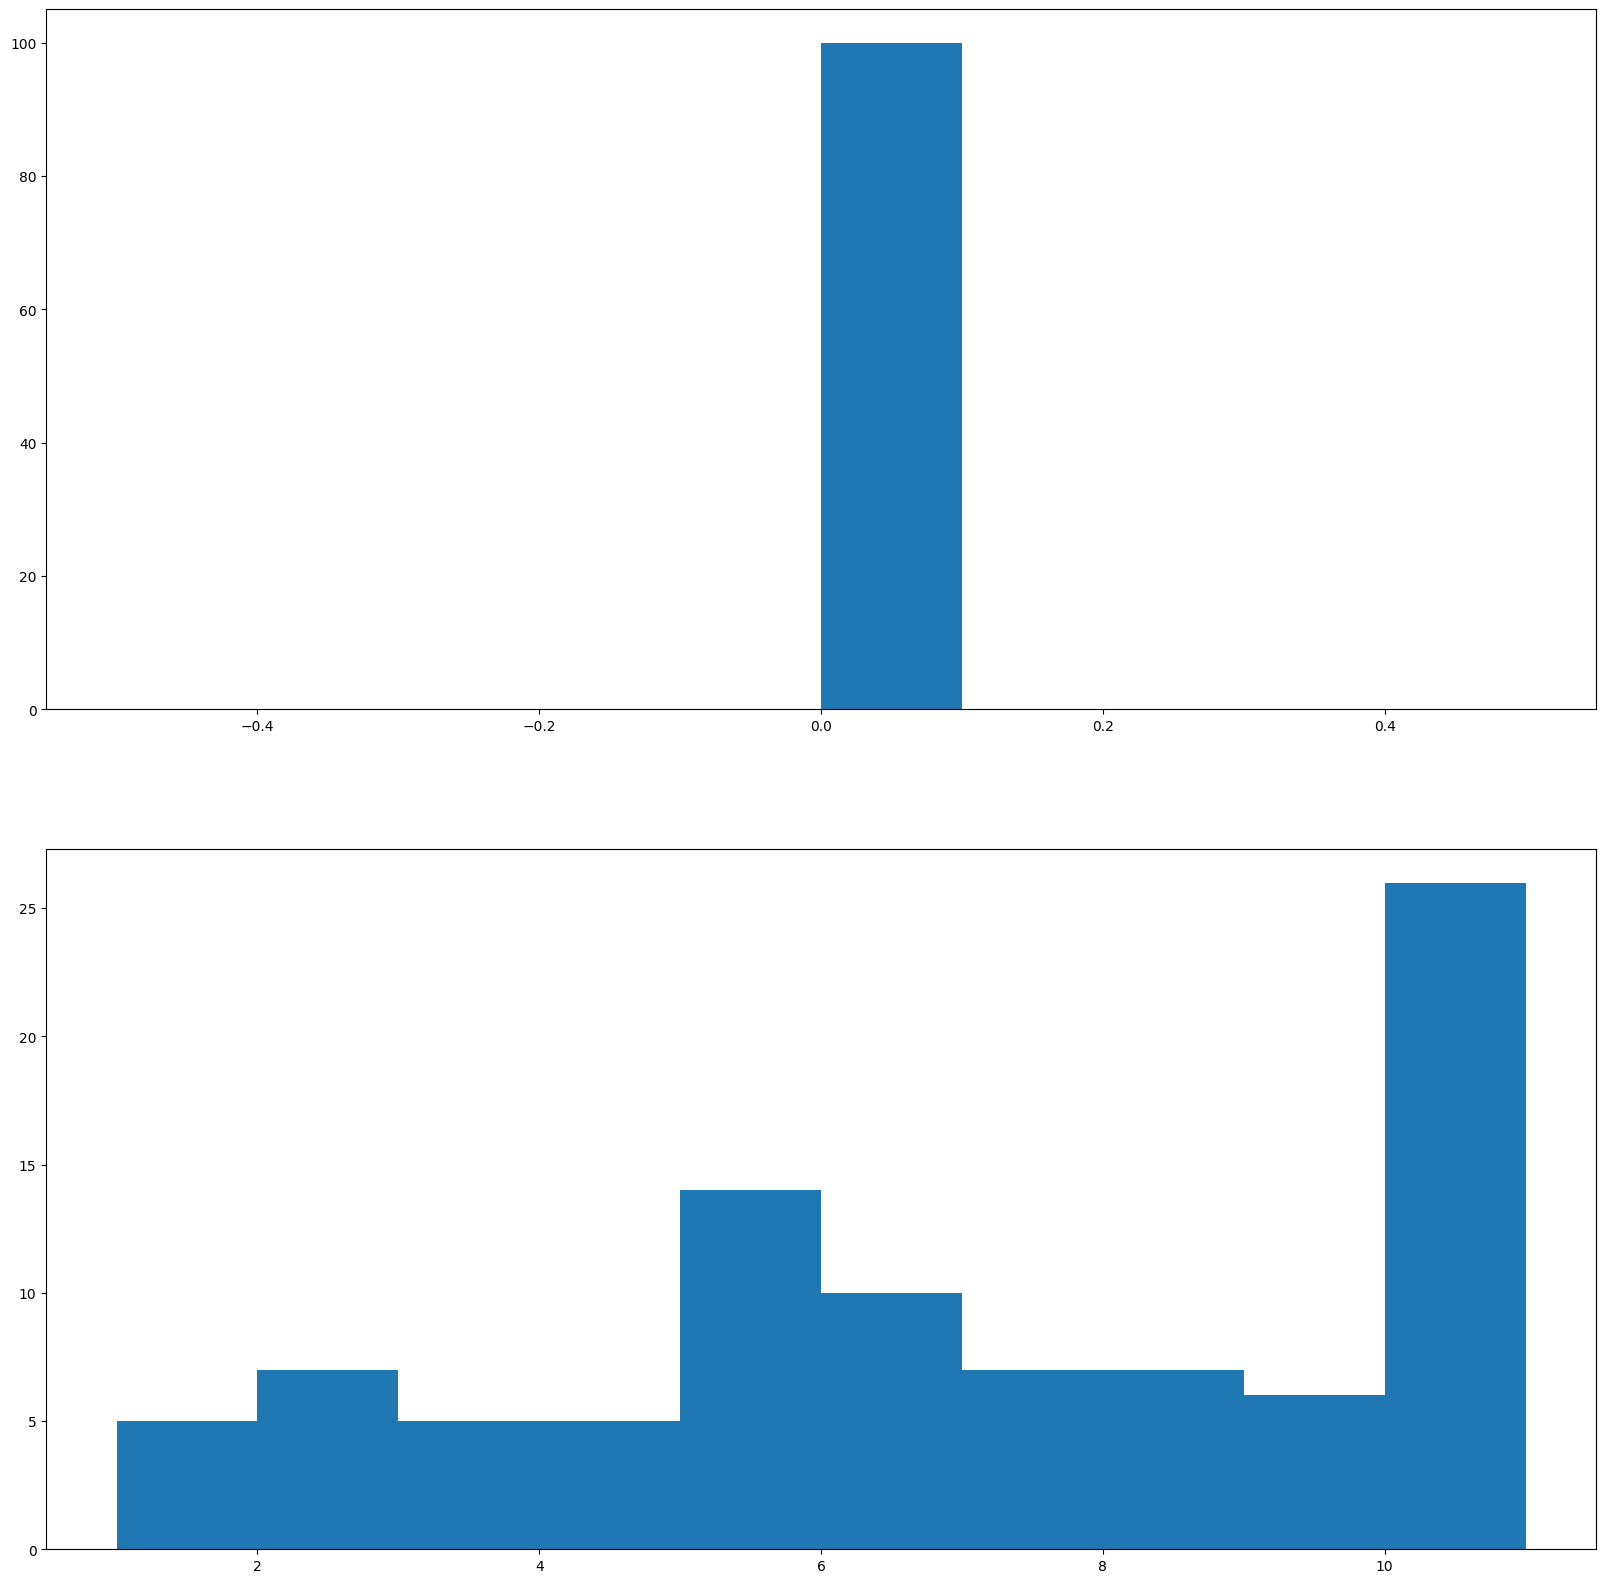

In [50]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(agent_data.xs(0, level="Step")[agent_data.xs(10, level="Step").Default == False].Leverage, bins = 10)
ax2.hist(agent_data.xs(500, level="Step")[agent_data.xs(500, level="Step").Default == False].Leverage, bins = 10)

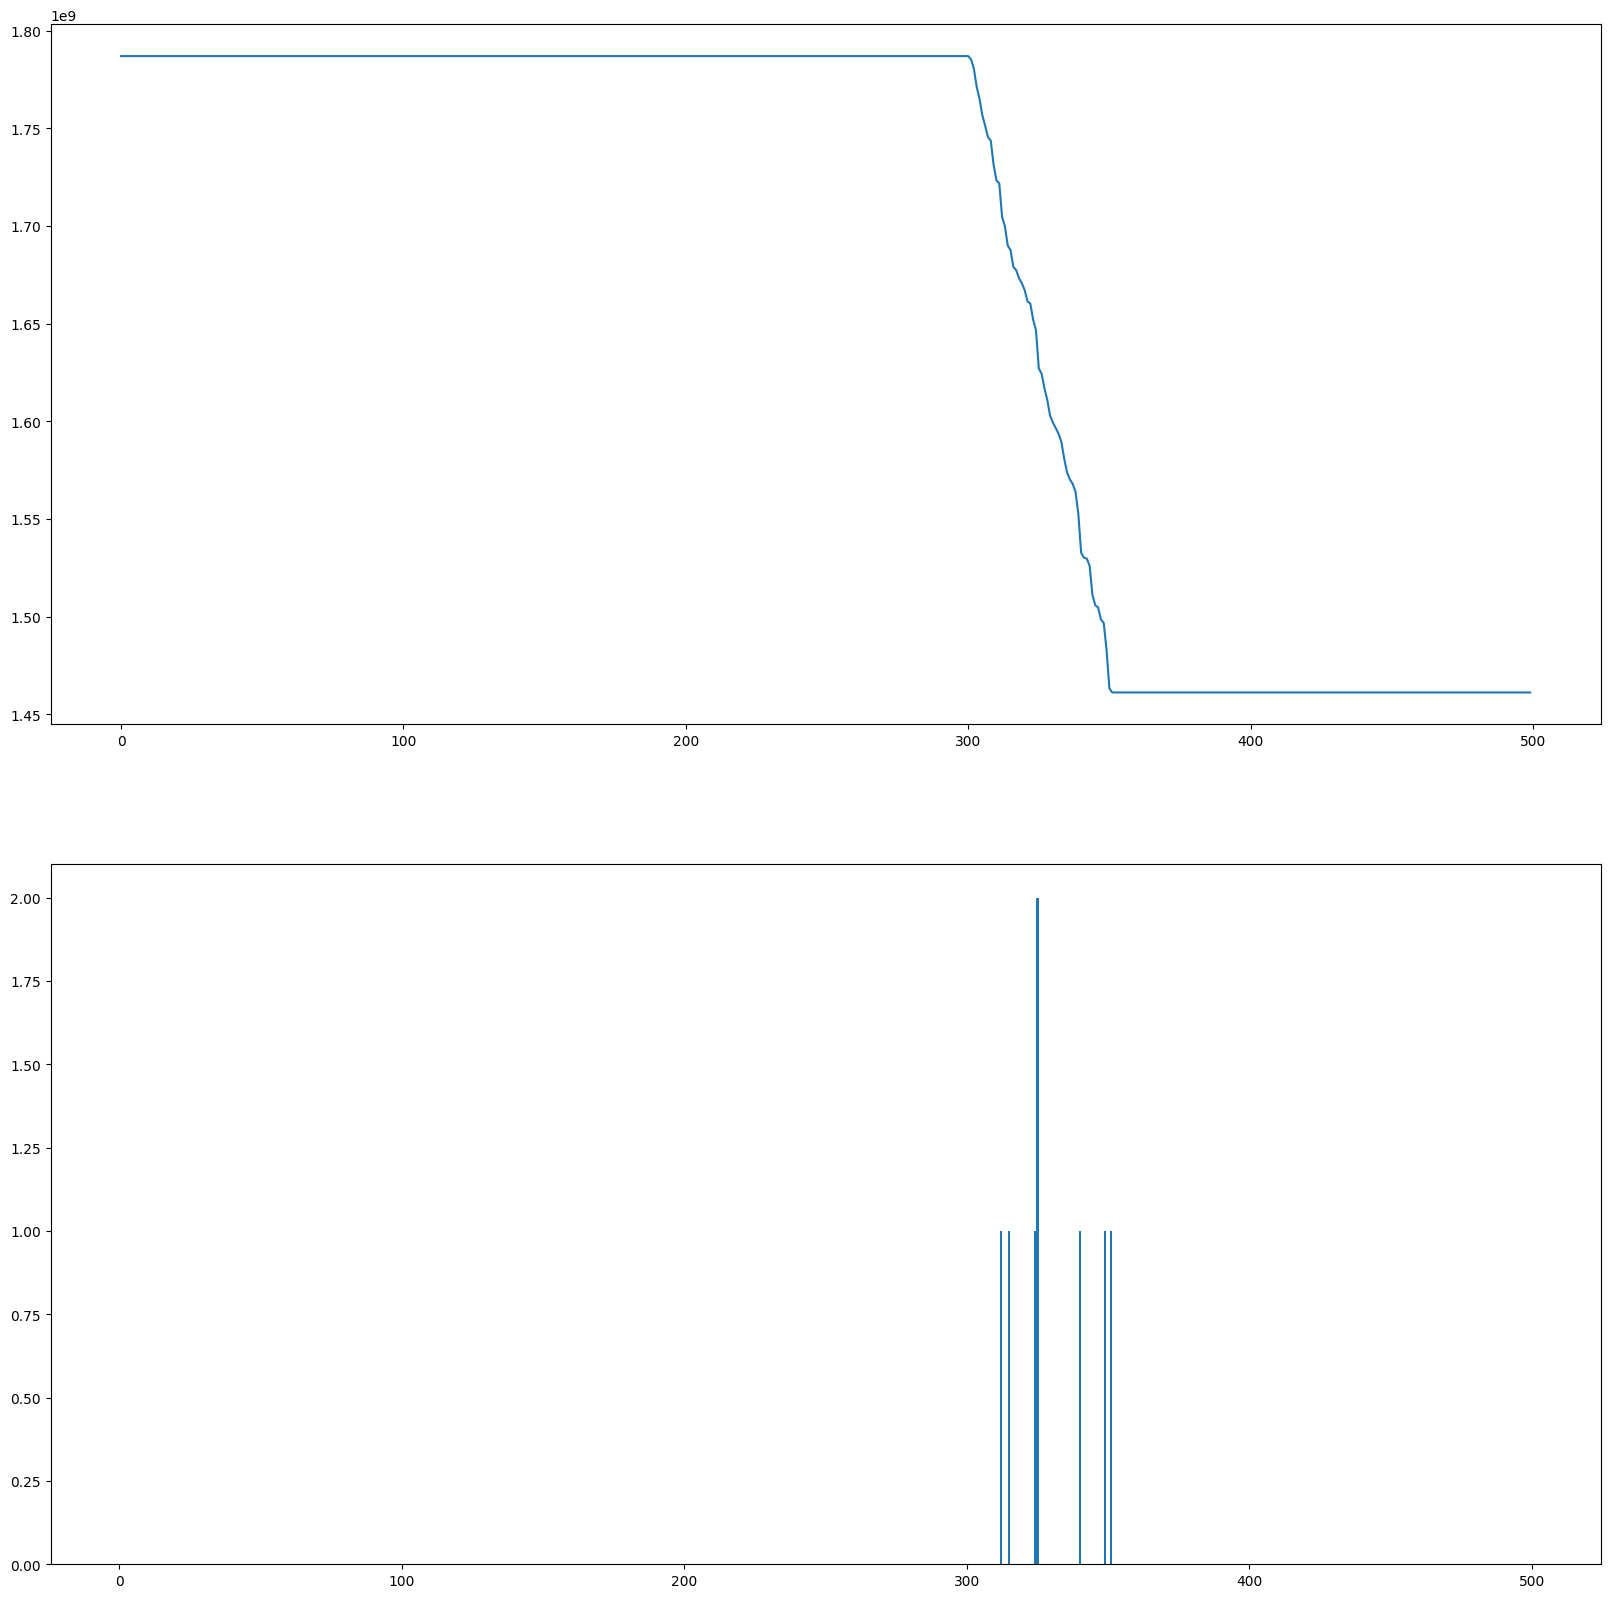

In [51]:
numberOfDefault = [agent_data.xs(i, level="Step")["Default"].sum() for i in range(simulationSteps)]
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(simulationSteps), [agent_data.xs(i, level="Step")["PortfolioValue"].sum() for i in range(simulationSteps)])
ax2.bar(range(1, simulationSteps), np.diff(numberOfDefault))
plt.show()

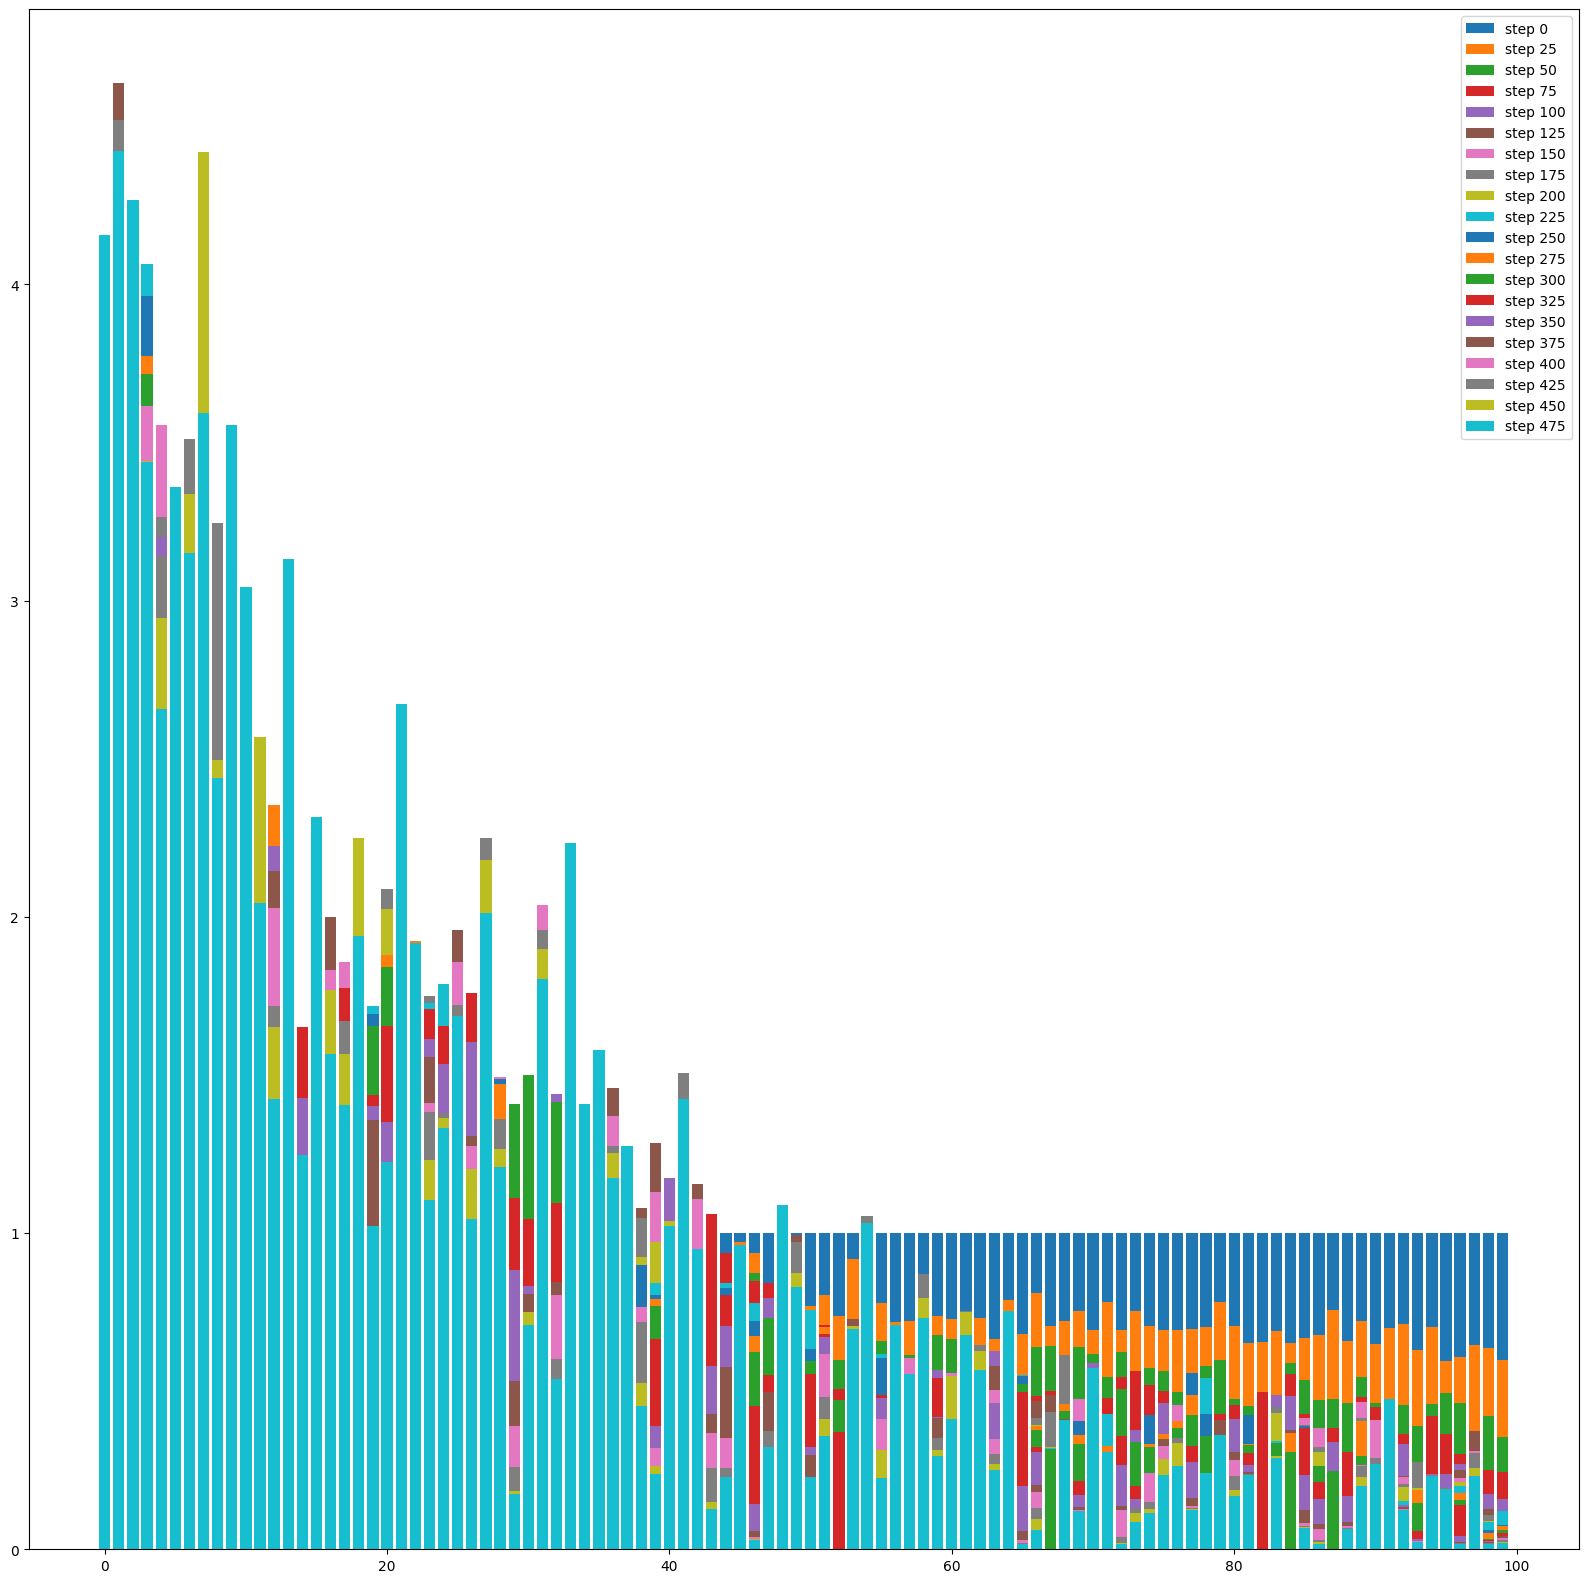

In [52]:
for i in range(simulationSteps):
    if i % (simulationSteps // 20) == 0:
        plt.bar(range(100),model_data["Trust Matrix"][i].sum(axis = 0), label = "step " + str(i))
plt.legend()

Step:  0


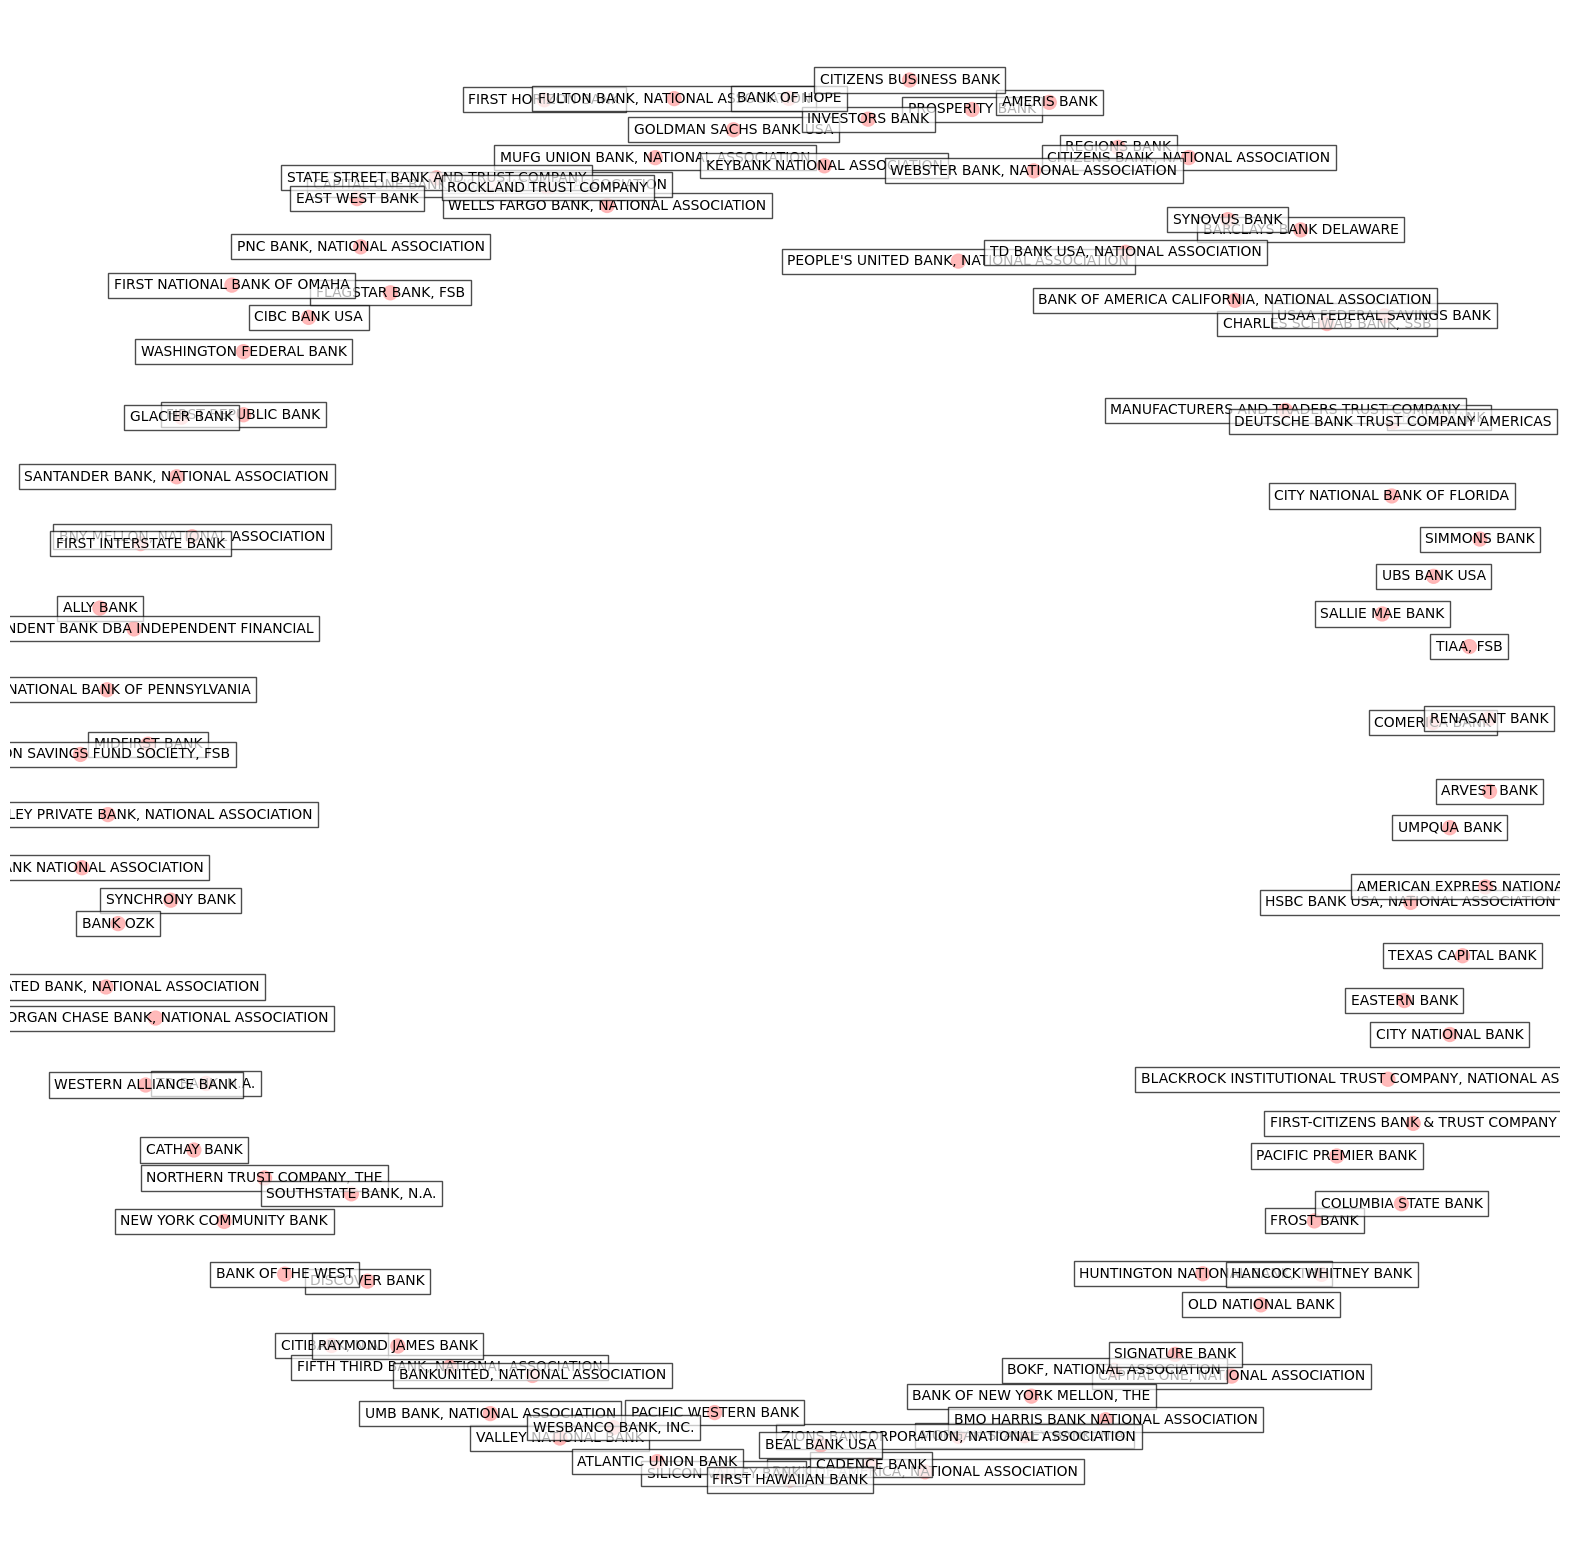

Step:  100


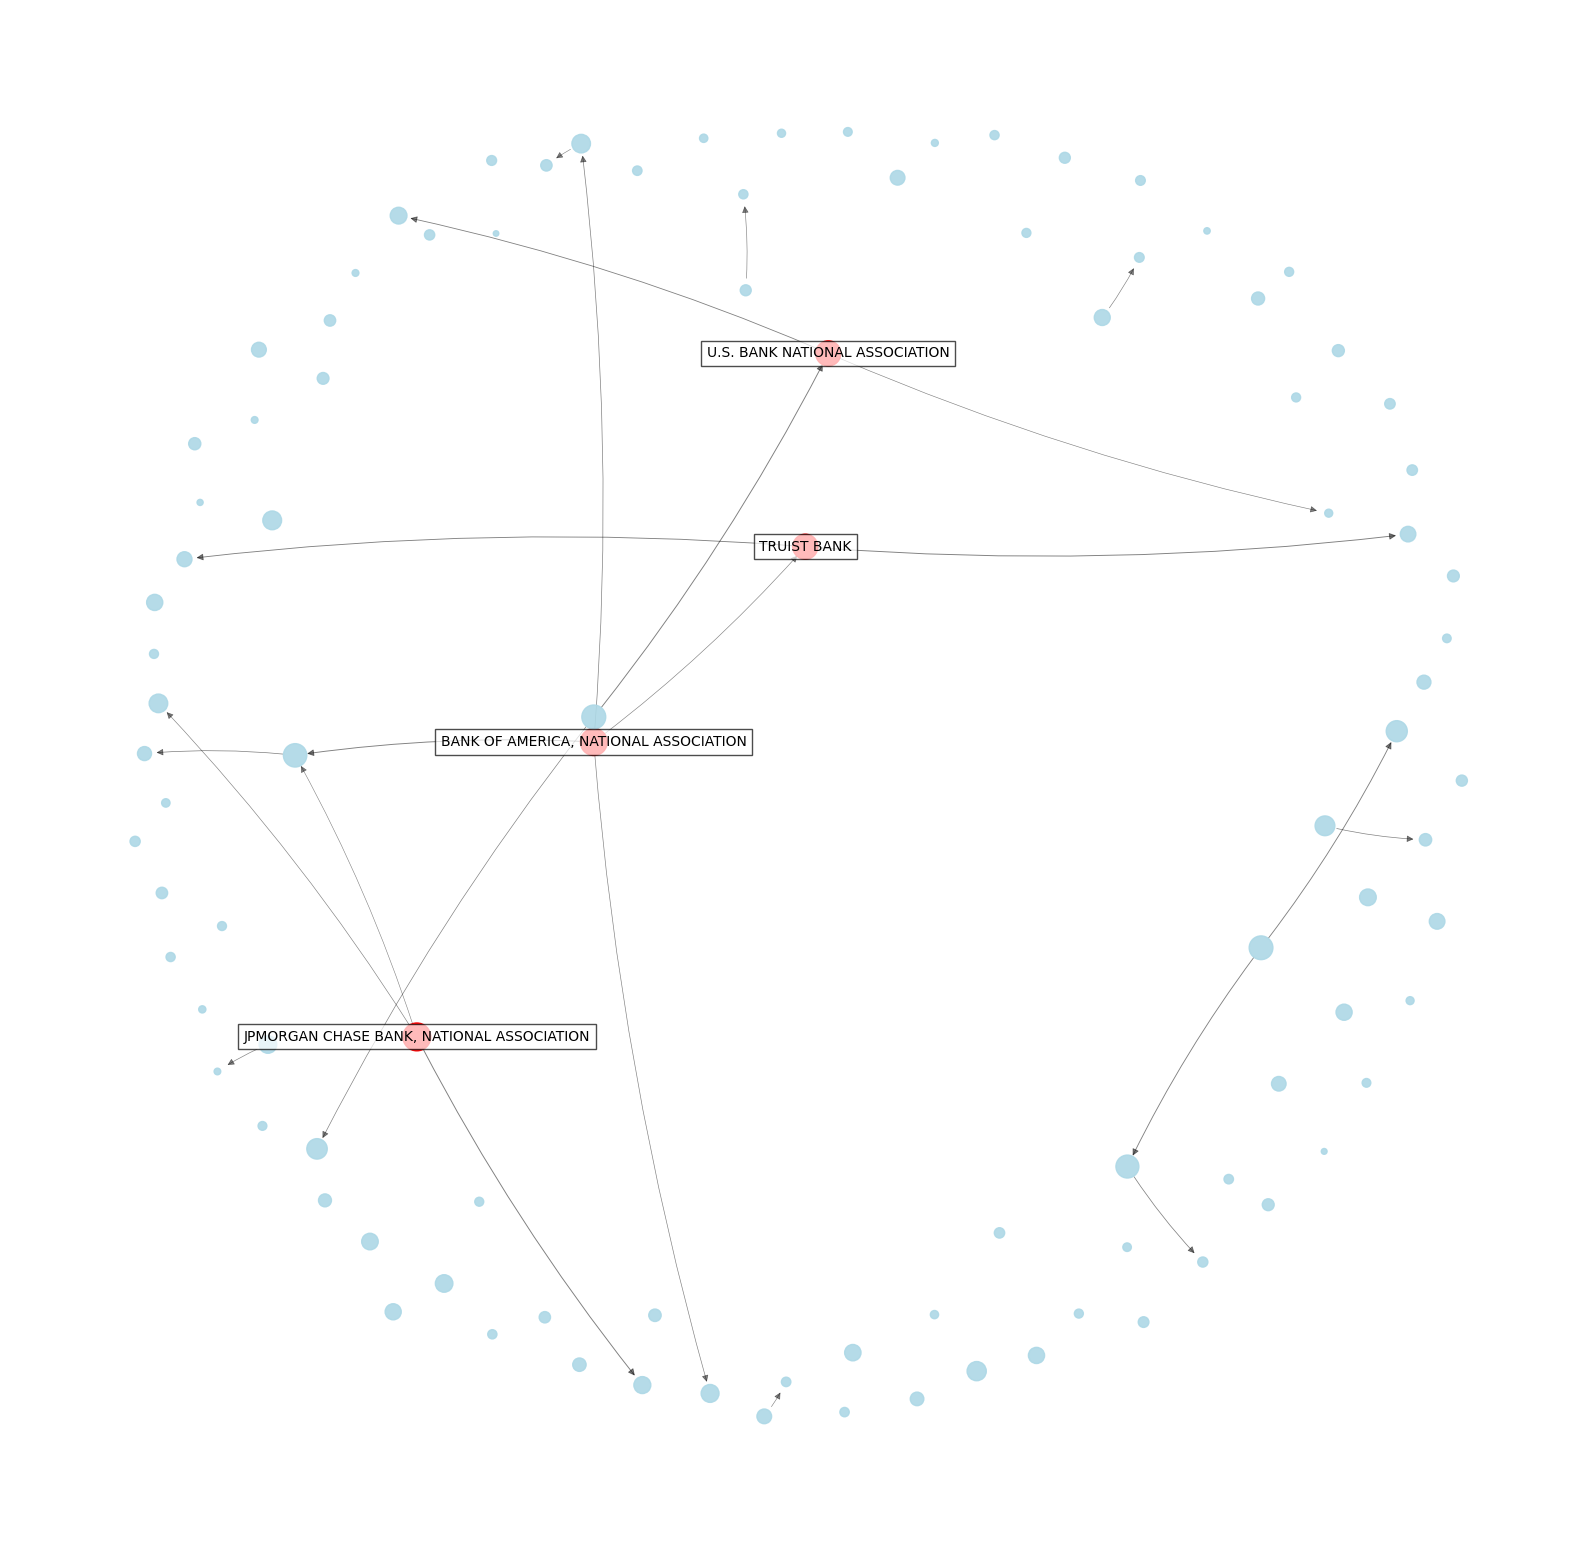

Step:  200


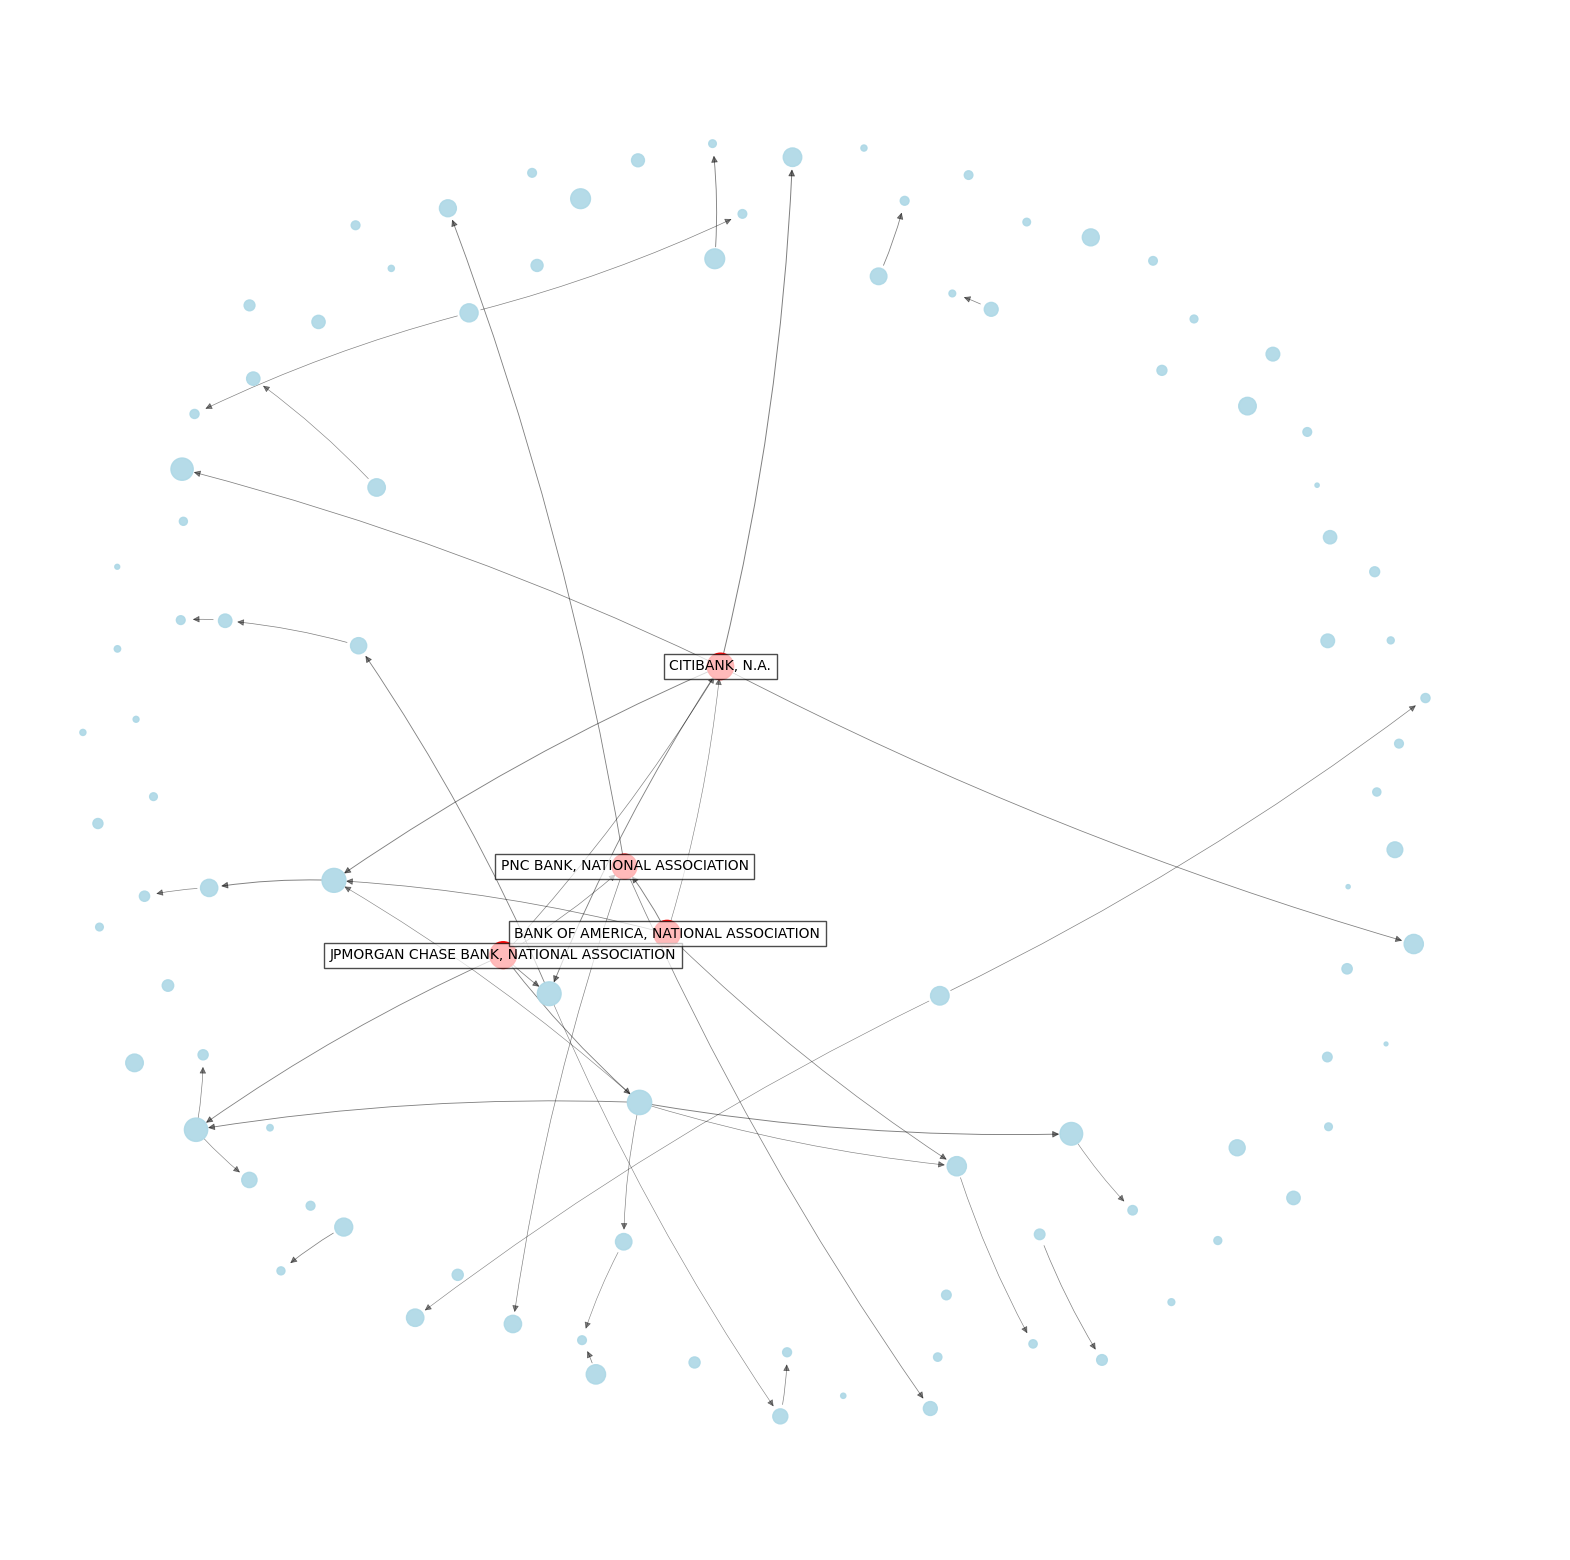

Step:  300


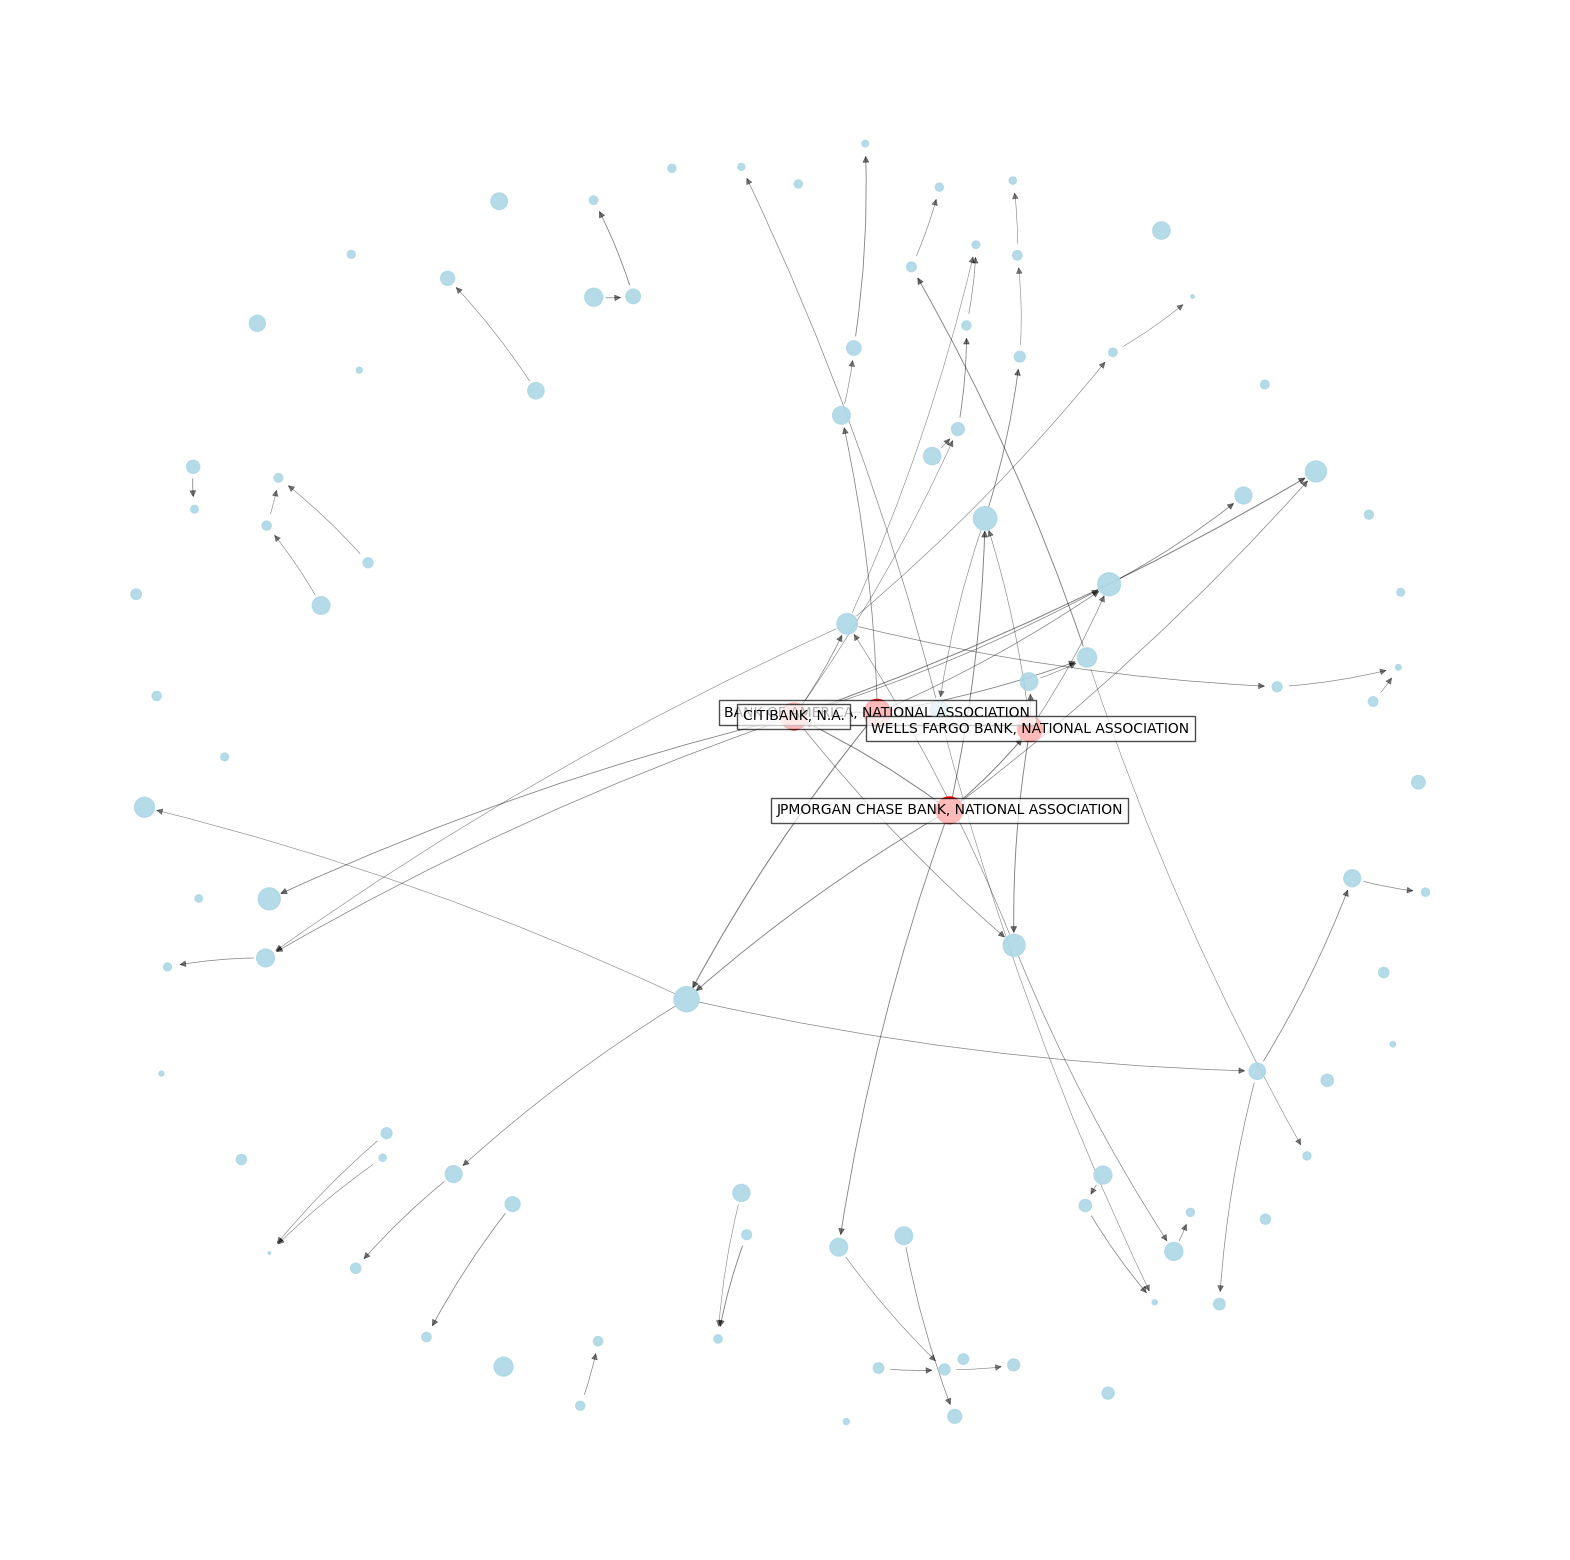

Step:  400


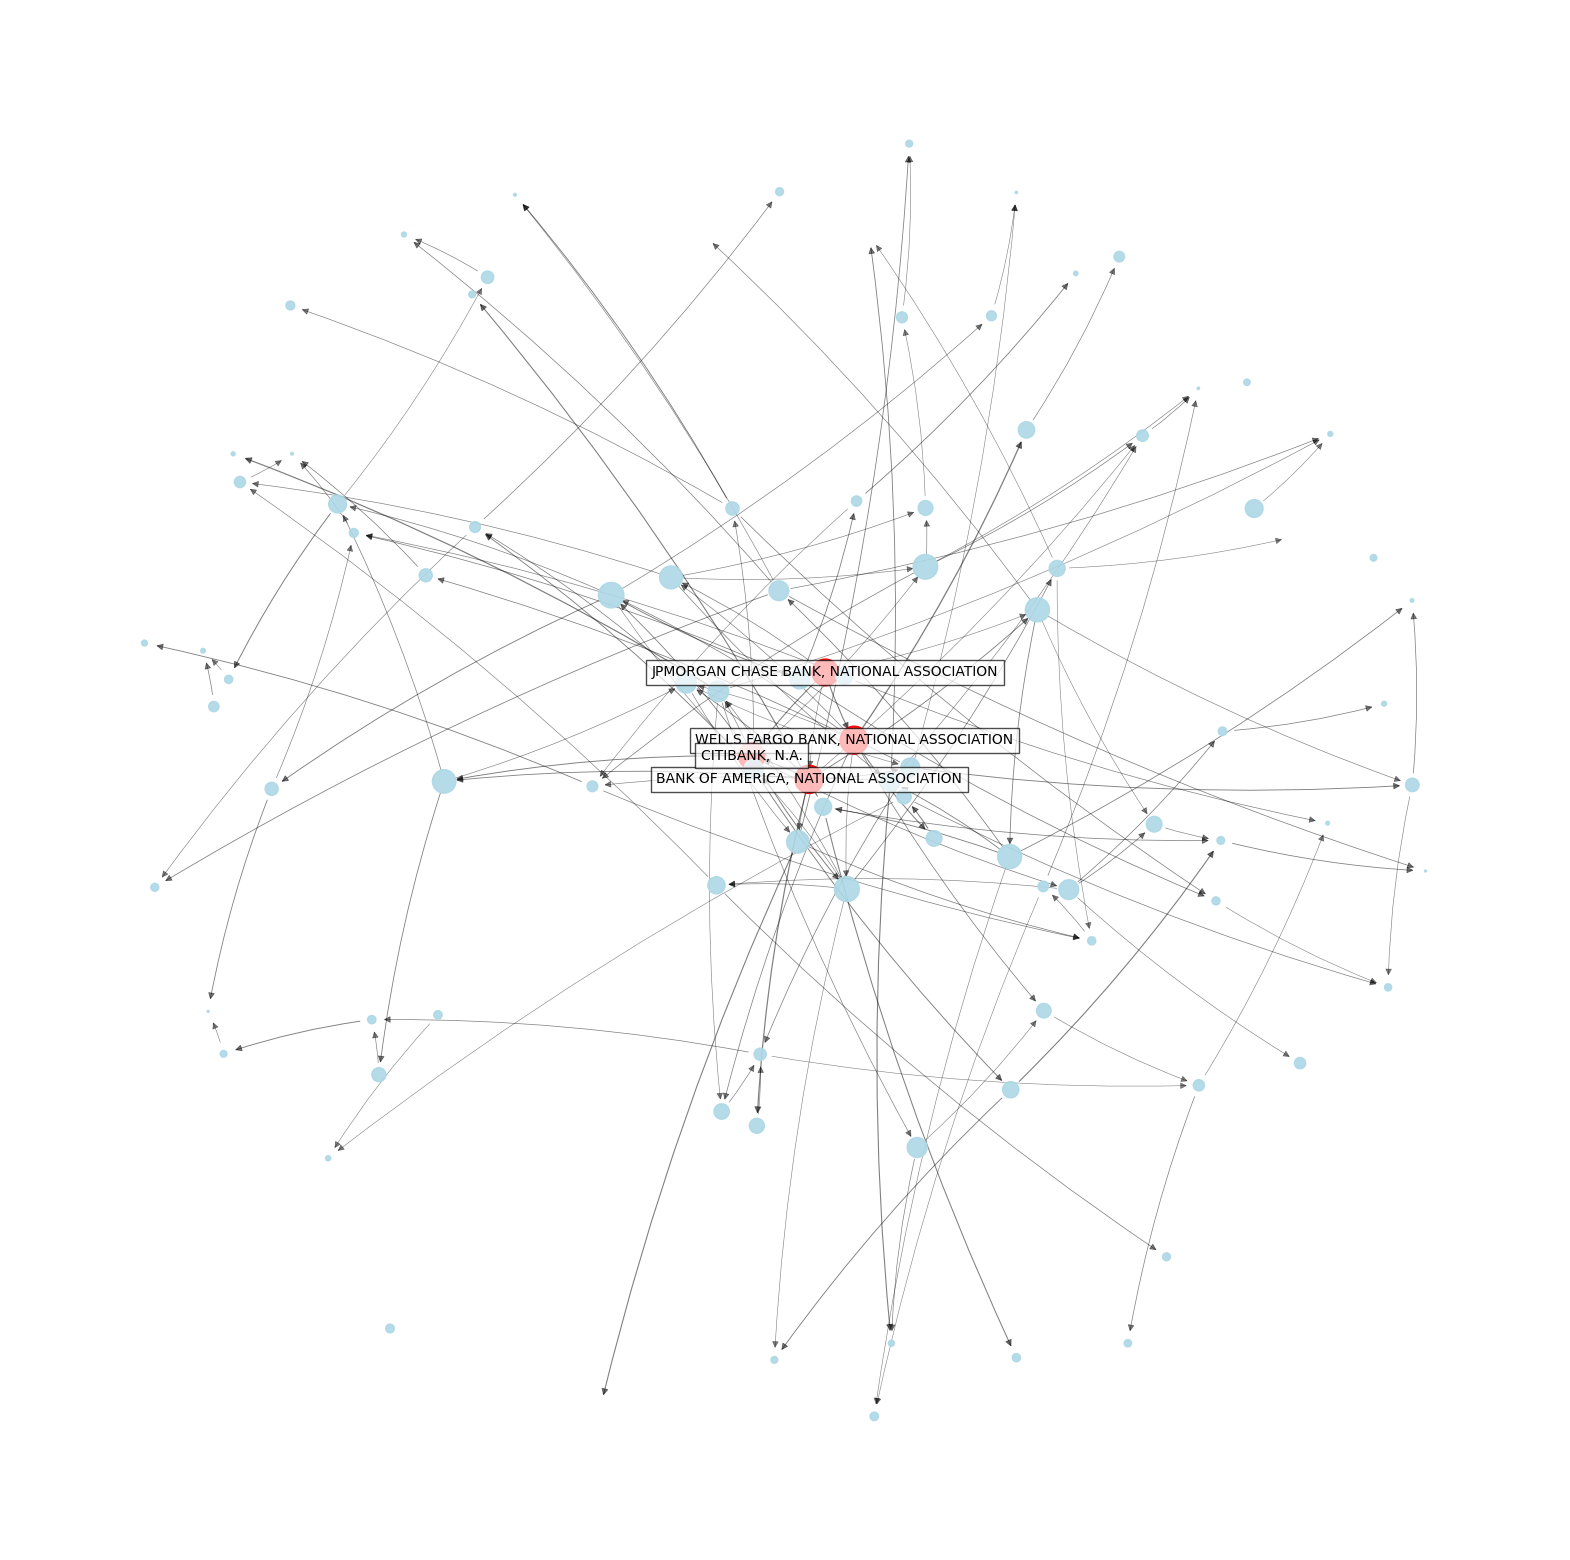

In [53]:
for i in range(0, simulationSteps, simulationSteps//5):
    print("Step: ", i)
    trustMatrix = model_data["Trust Matrix"].iloc[i]
    netWorkGraph(matrix=trustMatrix, model = model)

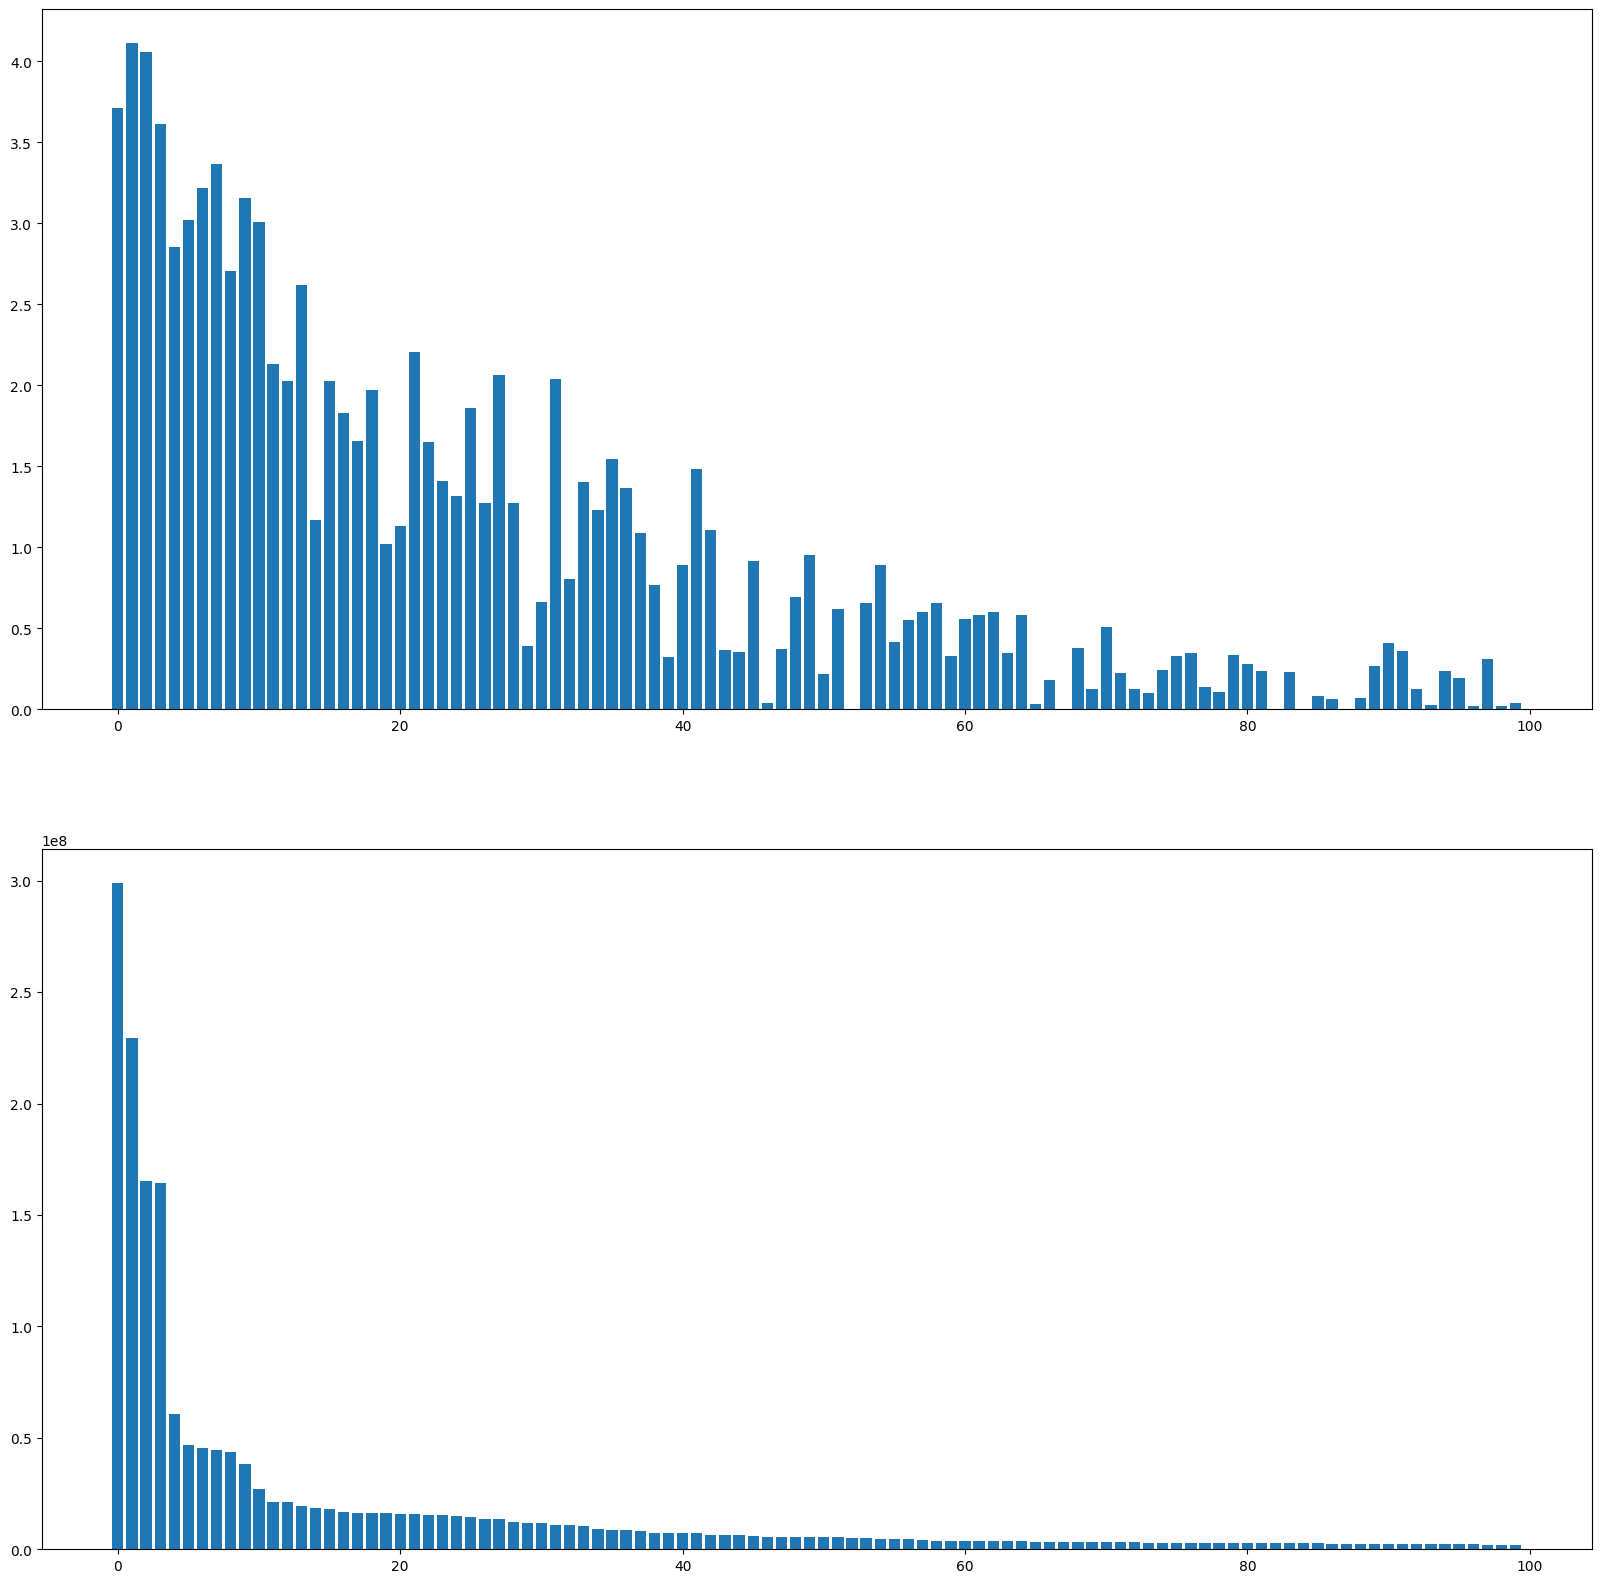

In [54]:
# bar chart of portfolio value
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.bar(range(model.N), trustMatrix.sum(axis = 0))
ax2.bar(range(model.N), agent_data.xs(0, level="Step")["Equity"])
plt.show()

In [55]:
model.banks.head(10)

0    JPMORGAN CHASE BANK, NATIONAL ASSOCIATION
1        BANK OF AMERICA, NATIONAL ASSOCIATION
2       WELLS FARGO BANK, NATIONAL ASSOCIATION
3                               CITIBANK, N.A.
4                                  TRUIST BANK
5               PNC BANK, NATIONAL ASSOCIATION
6               U.S. BANK NATIONAL ASSOCIATION
7                                TD BANK, N.A.
8                       GOLDMAN SACHS BANK USA
9            CAPITAL ONE, NATIONAL ASSOCIATION
Name: bank, dtype: object